In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')  
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report 
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
from google.colab import files
 
 
uploaded = files.upload()

Saving training.txt to training.txt


In [ ]:
#converting the text file to a dataframe
import io
train_df = pd.read_csv(io.BytesIO(uploaded['training.txt']),sep = ":",names = ['Class','Text'],encoding = 'ISO-8859-1')
#splitting the intent/class words from the actual text
train_df['Ans_type'] = train_df['Text'].apply(lambda x : x.split()[0])
train_df['Text']=train_df['Text'].str.split(n=1).str[1]

In [ ]:
# to create the final target variables
train_df.head()

,Class,Text,Ans_type
0,DESC,How did serfdom develop in and then leave Russ...,manner
1,ENTY,What films featured the character Popeye Doyle ?,cremat
2,DESC,How can I find a list of celebrities ' real na...,manner
3,ENTY,What fowl grabs the spotlight after the Chines...,animal
4,ABBR,What is the full form of .com ?,exp


In [ ]:
#checking bias of the training data
x = train_df['Class'].value_counts()*100/len(train_df['Class'])
print (x,x.shape)
print(x[x<1].count())

ENTY    23.472690
HUM     22.158944
DESC    21.382345
NUM     16.049702
LOC     15.376650
ABBR     1.559669
Name: Class, dtype: float64 (6,)
0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

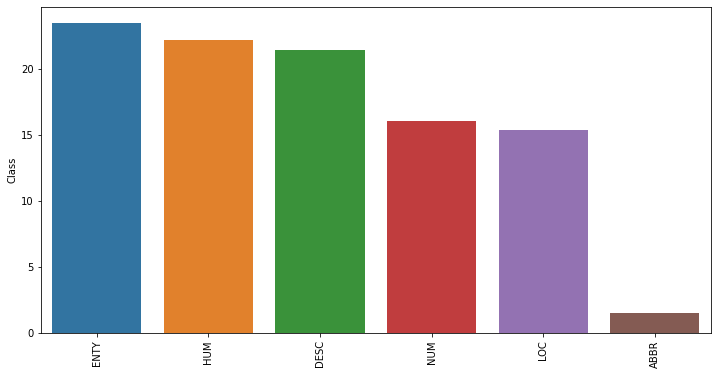

In [ ]:
#visualizing the bias of the data
f,ax = plt.subplots(figsize = (12,6))
sns.barplot(x.index,x)
plt.xticks(rotation = 90)

In [ ]:
#checking bias of the training data
y = train_df['Ans_type'].value_counts()*100/len(train_df['Ans_type'])
print (y,y.shape)
print(y[y<1].count())

In [ ]:
#visualizing the bias of the data
f,ax = plt.subplots(figsize = (12,6))
sns.barplot(y.index,y)
plt.xticks(rotation = 90)

In [ ]:
#check for missing values
train_df[train_df['Text'].isna() == 'True'].count()

In [ ]:
train_df['Tagcheck'] = train_df['Class']+ ' : ' + train_df['Ans_type']
train_df.head()

In [ ]:
#function to make the text lower case, remove punctuation, numbers etc..
def clean (line):
  line = line.lower()
  line = line.strip()
  line = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ',line)
  line = re.sub('\s+',' ',line)
  line = re.sub('\[[0-9]\]',' ',line)
  line = re.sub('\d+',' ',line)
  line = re.sub('[^\w\s]',' ',str(line).lower().strip())
  line = re.sub('\s+',' ',line)
  return line

In [ ]:
#Removing the question words from the list of stopwords
stops = list(stopwords.words('english'))
l = ['where','what','when','how','why','whom','which']
stopwordsf =[x for x in stops if x not in l]

In [ ]:
#stopword removal
def stopwords1(line):
  a= [i for i in line.split() if i not in stopwordsf]
  return ' '.join(a)

lemmatizer = WordNetLemmatizer()

#creating own tags based on nltk tagger
def ownpos_tag(tag):
  if tag.startswith('J'):
    return wordnet.ADJ
  if tag.startswith('V'):
    return wordnet.VERB
  if tag.startswith('N'):
    return wordnet.NOUN
  if tag.startswith('R'):
    return wordnet.ADV
  else:
    return None

# Lemmatization
def lemmetize(line):
  pos_tagged = nltk.pos_tag(nltk.word_tokenize(line))
  ownpos_tagged = list(map(lambda x: (x[0],ownpos_tag(x[1])),pos_tagged))
  a = []
  for item in ownpos_tagged:
    if item[1] == None:
      a.append(item[0])
    else:
      a.append(lemmatizer.lemmatize(item[0],item[1]))
  return ' '.join(a)

In [ ]:
# to extract "Final_text"
def processedtext(line):
  return lemmetize(stopwords1(clean(line)))

In [ ]:
train_df['Final_text'] = train_df['Text'].apply(lambda x : processedtext(x))
train_df.head() 

,Class,Text,Ans_type,Tagcheck,Final_text
0,DESC,How did serfdom develop in and then leave Russ...,manner,DESC : manner,how serfdom develop leave russia
1,ENTY,What films featured the character Popeye Doyle ?,cremat,ENTY : cremat,what film featured character popeye doyle
2,DESC,How can I find a list of celebrities ' real na...,manner,DESC : manner,how find list celebrity real name
3,ENTY,What fowl grabs the spotlight after the Chines...,animal,ENTY : animal,what fowl grab spotlight chinese year monkey
4,ABBR,What is the full form of .com ?,exp,ABBR : exp,what full form com


In [ ]:
#Labelling the target variables
le1 = LabelEncoder().fit(train_df['Ans_type'])
le2 = LabelEncoder().fit(train_df['Class'])
train_df['Ans_type'] = le1.transform(train_df['Ans_type'])
train_df['Class'] = le2.transform(train_df['Class'])
print(train_df['Ans_type'].nunique())
print(train_df['Class'].nunique())

47
6


In [ ]:
#splitting the data making sure that each sample has atleast 5 samples in the training data
X = train_df.drop('Ans_type',axis = 1)
min_count = 0
while min_count < 5:
  x_train, x_test, y_train, y_test = train_test_split(X,train_df['Ans_type'],test_size = 0.2, shuffle = True)
  min_count = y_train.value_counts().min()

In [ ]:
#preparing training and testing datasets for two different models
x_train1 = x_train['Final_text']
x_train2 = x_train['Final_text']
x_test1 = x_test['Final_text']
x_test2 = x_test['Final_text']
y_train1 = y_train
y_test1 = y_test
y_train2 = x_train['Class']
y_test2 = x_test['Class']

In [ ]:
#vectorization for first model
tfidf_vect = TfidfVectorizer(use_idf = True)
x_train1 = tfidf_vect.fit_transform(x_train1)
x_test1 = tfidf_vect.transform(x_test1)

In [ ]:
#oversampling the minority classes for first model
x_train1, y_train1 = SMOTE(k_neighbors = 4).fit_resample(x_train1, y_train1)

In [ ]:
#model building and classification for first model
model = LinearSVC()
model.fit(x_train1,y_train1)
y_pred1 = model.predict(x_test1)

In [ ]:
y_pred1 = le1.inverse_transform(y_pred1)
y_test1 = le1.inverse_transform(y_test1)

In [ ]:
#accuracy and metrics for first model
acc1 = accuracy_score(y_test1,y_pred1)*100
print (acc1)
print(classification_report(y_test1,y_pred1))

In [ ]:
#vectorization for second model
tfidf_vect.fit(x_train2)
x_train2 = tfidf_vect.transform(x_train2)
x_test2 = tfidf_vect.transform(x_test2)

In [ ]:
#oversampling the minority classes for second model
x_train2, y_train2 = SMOTE(k_neighbors = 4).fit_resample(x_train2, y_train2)

In [ ]:
#model building and classification for second model
model.fit(x_train2,y_train2)
y_pred2 = model.predict(x_test2)

In [ ]:
y_pred2 = le2.inverse_transform(y_pred2)
y_test2 = le2.inverse_transform(y_test2)

In [ ]:
#accuracy and metrics for second model
acc2 = accuracy_score(y_test2,y_pred2)*100
print (acc2)
print(classification_report(y_test2,y_pred2))

97.0883209317373
              precision    recall  f1-score   support

        ABBR       0.95      0.95      0.95        55
        DESC       0.97      0.97      0.97       679
        ENTY       0.96      0.95      0.96       744
         HUM       0.97      0.97      0.97       650
         LOC       0.97      0.99      0.98       463
         NUM       0.98      0.99      0.99       500

    accuracy                           0.97      3091
   macro avg       0.97      0.97      0.97      3091
weighted avg       0.97      0.97      0.97      3091

